# Install Python Libs

In [4]:
import sys
!{sys.executable} -m pip install pandas==2.1.1 thefuzz==0.22.1 seaborn==0.13.0 matplotlib==3.8.0

# Load Python Libs

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from thefuzz import fuzz
from thefuzz import process as fuzz_process

# Initialize Data File Variables

In [6]:
PARQUET_FILE_TO_EXPORT_INTO_SNOWFLAKE = './data/transactions_data_frame_and_customers_data_frame_merged.parquet'
CSV_FILE_TO_EXPORT_INTO_TABLEAU = './data/transactions_data_frame_and_customers_data_frame_merged.csv'
CUSTOMERS_DATA_FILE_TO_LOAD = './data/customers.csv'
TRANSACTIONS_DATA_FILE_TO_LOAD = './data/transactions.csv'

# Load CSV Data

Loading `customers.csv` and `transactions.csv` via `pandas.read_csv` method.

In [7]:
customers_data_frame = pd.read_csv(
    filepath_or_buffer=CUSTOMERS_DATA_FILE_TO_LOAD,
    sep=',',
    header=0,
    dtype={'customer_id':int, 'customer_name':str, 'email':str}
)

transactions_data_frame = pd.read_csv(
    filepath_or_buffer=TRANSACTIONS_DATA_FILE_TO_LOAD,
    sep=',',
    header=0,
    dtype={'transaction_id':int, 'customer_name':str, 'amount':int},
    parse_dates=['transaction_date']
)

## Enrich Data Frames
To be able to analize data preciesly, we need to extract some features available and store them alongside with the original columns.

In [8]:
transactions_data_frame['transaction_date_year'] = transactions_data_frame.transaction_date.dt.year.astype(str)
transactions_data_frame['transaction_date_month_name'] = transactions_data_frame.transaction_date.dt.month_name()
transactions_data_frame['transaction_date_month'] = transactions_data_frame.transaction_date.dt.month
transactions_data_frame['transaction_date_day'] = transactions_data_frame.transaction_date.dt.day
transactions_data_frame['transaction_date_day_of_week'] = transactions_data_frame.transaction_date.dt.day_of_week
transactions_data_frame['transaction_date_day_name'] = transactions_data_frame.transaction_date.dt.day_name()
transactions_data_frame['transaction_date_quarter'] = transactions_data_frame.transaction_date.dt.quarter.astype(str)
transactions_data_frame['transaction_date_is_month_start'] = transactions_data_frame.transaction_date.dt.is_month_start
transactions_data_frame['transaction_date_is_month_end'] = transactions_data_frame.transaction_date.dt.is_month_end
transactions_data_frame['transaction_date_is_quarter_start'] = transactions_data_frame.transaction_date.dt.is_quarter_start
transactions_data_frame['transaction_date_is_quarter_end'] = transactions_data_frame.transaction_date.dt.is_quarter_end

In [9]:
customers_data_frame.info()
transactions_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    10 non-null     int64 
 1   customer_name  10 non-null     object
 2   email          10 non-null     object
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   transaction_id                     10 non-null     int64         
 1   customer_name                      10 non-null     object        
 2   amount                             10 non-null     int64         
 3   transaction_date                   10 non-null     datetime64[ns]
 4   transaction_date_year              10 non-null     object        
 5   transaction_date_month_na

## Data Assertion

In [10]:
assert transactions_data_frame.transaction_date_year.nunique() == 1, "The intention of the Notebook was to analyze data for a year (either zero on many detected), however it can be still executed for multi-years data that might lead to some side effects on charts."

# Fuzzy Join

All transactions will be joined with customers assuming that each transaction could have only one customer `(m:1)`.\
The use of the `extractOne` from the `fuzz` lib. returns one record (customer) for a transaction with its best score (based on the `customer_name` column being used as a key)\
We expect that correct customer names are sitiing in the `customers.csv` file, so `customer_name` will become `customer_name_right` with corrected data in it.

Columns of the merged data set `transactions_data_frame_and_customers_data_frame_merged`:

**Transactins columns:**\
`transaction_id` - transaction id key from the transactions file.\
`customer_name_left` - customer, performed a purchase, from the transactions file.\
`amount` - amount sold, an integer, from the transactions file.\
`transaction_date` - transaction date when sale happened, from the transactions file.

**Enriched columns:**\
`transaction_date_year` - feature, year from `transaction_date`.\
`transaction_date_month_name` - feature, month name from `transaction_date`.\
`transaction_date_month` - feature, month number from `transaction_date`.\
`transaction_date_day` - feature, day number from `transaction_date`.\
`transaction_date_day_of_week` - feature, week day number from `transaction_date`.\
`transaction_date_day_name` - feature, day name from `transaction_date`.\
`transaction_date_quarter` - feature, quarter number from `transaction_date`.\
`transaction_date_is_month_start` - feature, shows if the `transaction_date` is the start of the month.\
`transaction_date_is_month_end` - feature, shows if the `transaction_date` is the end of the month.\
`transaction_date_is_quarter_start` - feature, shows if the `transaction_date` is the start of the quarter.\
`transaction_date_is_quarter_end` - feature, shows if the `transaction_date` is the end of the quarter.

**Fuzzy join columns:**\
`customer_name_fuzzy_key` - field got used to find the right customer records via `fuzz` lib comparing customer names from transactions to customers data.\
`customer_name_fuzzy_score` - a score of the fuzzy matched record based on `customer_name` column.\
`customer_id` - customer id key from the customers file.\
`customer_name_right` - customer name from the customers file, whic is treated as the corrected one.\
`email` - an email from the customers file.

In [11]:
transactions_data_frame[['customer_name_fuzzy_key', 'customer_name_fuzzy_score']] = \
transactions_data_frame.apply(lambda x: pd.Series(fuzz_process.extractOne(x.customer_name, customers_data_frame.customer_name, scorer=fuzz.token_sort_ratio)[:2]), axis=1)
transactions_data_frame_and_customers_data_frame_merged = transactions_data_frame.merge(
    right=customers_data_frame,
    how='left',
    left_on='customer_name_fuzzy_key',
    right_on='customer_name',
    suffixes=['_left', '_right'])

In [12]:
transactions_data_frame_and_customers_data_frame_merged

,transaction_id,customer_name_left,amount,transaction_date,transaction_date_year,transaction_date_month_name,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_name,transaction_date_quarter,transaction_date_is_month_start,transaction_date_is_month_end,transaction_date_is_quarter_start,transaction_date_is_quarter_end,customer_name_fuzzy_key,customer_name_fuzzy_score,customer_id,customer_name_right,email
0,101,John Smith,784,2023-01-31,2023,January,1,31,1,Tuesday,1,False,True,False,False,John Smith,100,1,John Smith,john.smith@email.com
1,102,Jane Doe,659,2023-02-28,2023,February,2,28,1,Tuesday,1,False,True,False,False,Jane Doe,100,2,Jane Doe,jane.doe@email.com
2,103,Michael Jonson,729,2023-03-31,2023,March,3,31,4,Friday,1,False,True,False,True,Micheal Jonson,93,3,Micheal Jonson,m.johnson@email.com
3,104,Chris Lee,292,2023-04-30,2023,April,4,30,6,Sunday,2,False,True,False,False,Chris Lee,100,4,Chris Lee,c.lee@email.com
4,105,Katherine Davis,935,2023-05-31,2023,May,5,31,2,Wednesday,2,False,True,False,False,Katherine Davis,100,5,Katherine Davis,k.davis@email.com
5,106,David Martinez,863,2023-06-30,2023,June,6,30,4,Friday,2,False,True,False,True,David Martinez,100,6,David Martinez,d.martinez@email.com
6,107,Sarah Brown,807,2023-07-31,2023,July,7,31,0,Monday,3,False,True,False,False,Sara Brownn,91,7,Sara Brownn,s.brown@email.com
7,108,James Wilson,459,2023-08-31,2023,August,8,31,3,Thursday,3,False,True,False,False,James Wilson,100,8,James Wilson,j.wilson@email.com
8,109,Patricia Taylor,109,2023-09-30,2023,September,9,30,5,Saturday,3,False,True,False,True,Patricia Taylor,100,9,Patricia Taylor,p.taylor@email.com
9,110,Robet Miller,823,2023-10-31,2023,October,10,31,1,Tuesday,4,False,True,False,False,Robert Miller,96,10,Robert Miller,r.miller@email.com


# Export Data to Parquet File to Load Into Snowflake & Tableau
Exporting into a parquet file `/data/transactions_data_frame_and_customers_data_frame_merged.*` to upload the file into snowlfake & Tableau, usin Snowflake UI & Tableau data import features.

In [13]:
columns = [
    'transaction_id',
    'amount',
    'customer_id',
    'customer_name_right',
    'email',
    'transaction_date_year',
    'transaction_date_month_name',
    'transaction_date_day',
    'transaction_date_day_name',
    'transaction_date_quarter',
    'transaction_date_is_month_start',
    'transaction_date_is_month_end',
    'transaction_date_is_quarter_start',
    'transaction_date_is_quarter_end']

transactions_data_frame_and_customers_data_frame_merged.astype({'transaction_date': str})[columns].to_parquet(
    PARQUET_FILE_TO_EXPORT_INTO_SNOWFLAKE)

columns = [
    'amount',
    'customer_name_right',
    'email',
    'transaction_date',
    'transaction_date_year',
    'transaction_date_month_name',
    'transaction_date_day_name',
    'transaction_date_quarter']

transactions_data_frame_and_customers_data_frame_merged.astype({'transaction_date': str})[columns].to_csv(
    CSV_FILE_TO_EXPORT_INTO_TABLEAU)

# Sales Trends Analysis

There are 4 charts showing sales trends and patterns:

- **Total Amount Sold Per Week Day** - represents the amount of sales per each week day, it is clear that the trends slows down when the week reaches the end, there is a gap in the middle of the week shown.
- **Total Amount Sold Per Month** - represents sales per month (in blue, could be overlapped completelly) and amount of sales happened at the last day of each month (in red, overlapping). This shows that all the sales happened right at the end of each month (everything is in red). **September seems to be an outlier based on the amount, moreover the amount is equal to ID which is weird.**
- **Total Amount Sold Per Quarter** - represents sales per quarter (in blue, overlapped) and the amount of sales happened at the last day of each quarter (in red, overlapping)
- **Total Amount Sold Per Year** - represents total sales per year

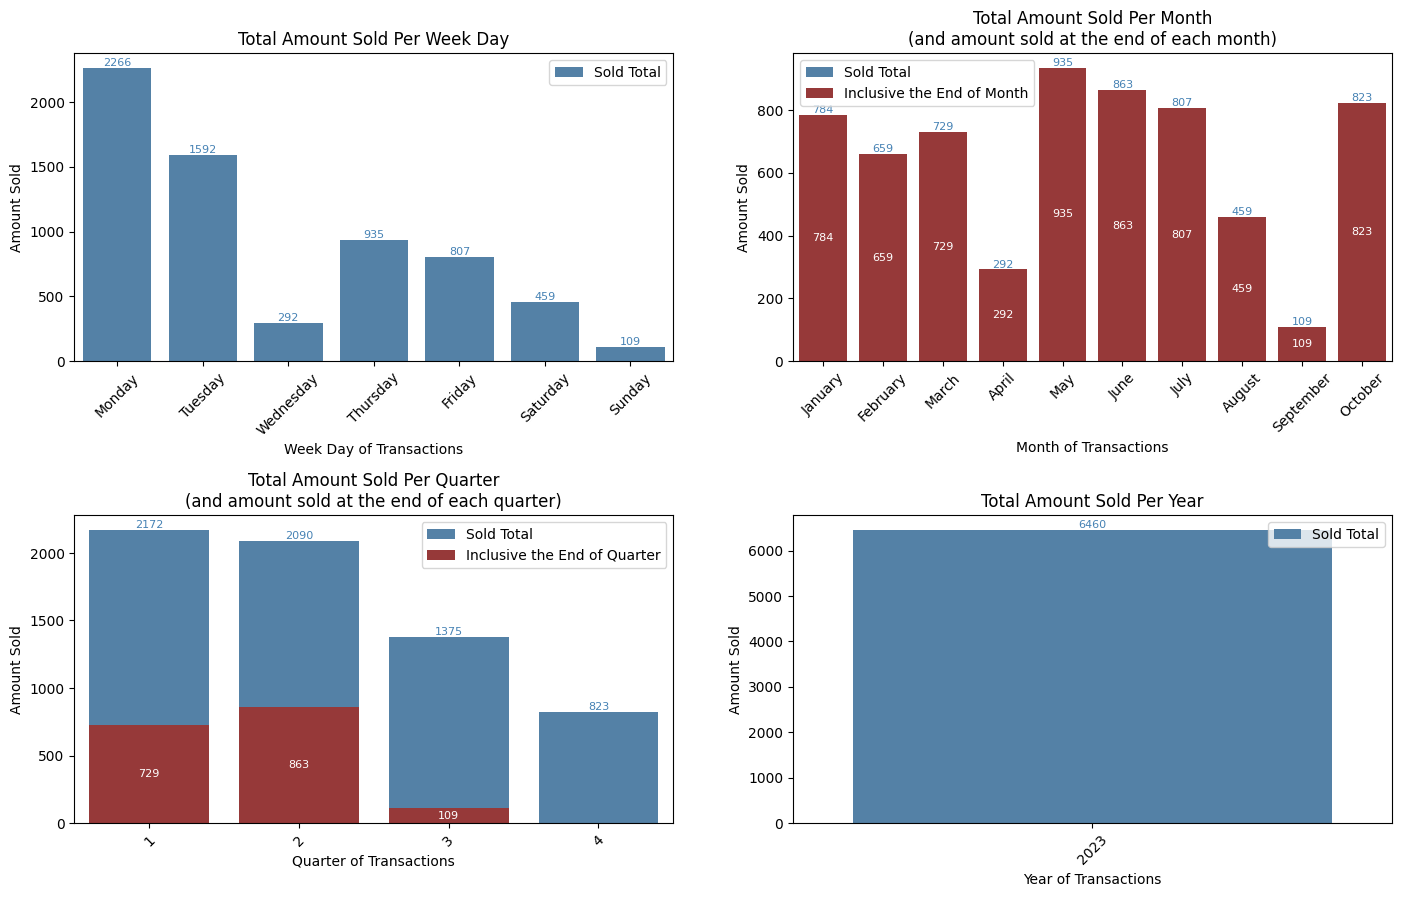

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

charts_column_label_data = [
    { 'title': 'Total Amount Sold Per Week Day',
      'y_column_name': 'amount', 'x_column_name': 'transaction_date_day_name', 'x_label': 'Week Day of Transactions',
      'y_label': 'Amount Sold', 'sort_column': 'transaction_date_day_of_week', 'hue': 'index < 0','legend_labels': ['Sold Total']
    },
    { 'title': 'Total Amount Sold Per Month\n(and amount sold at the end of each month)',
      'y_column_name': 'amount', 'x_column_name': 'transaction_date_month_name', 'x_label': 'Month of Transactions',
      'y_label': 'Amount Sold', 'sort_column': 'transaction_date_month', 'hue': 'transaction_date_is_month_end', 'legend_labels': ['Sold Total', 'Inclusive the End of Month']
    },
    { 'title': 'Total Amount Sold Per Quarter\n(and amount sold at the end of each quarter)',
      'y_column_name': 'amount', 'x_column_name': 'transaction_date_quarter', 'x_label': 'Quarter of Transactions',
      'y_label': 'Amount Sold', 'sort_column': 'transaction_date_quarter', 'hue': 'transaction_date_is_quarter_end', 'legend_labels': ['Sold Total', 'Inclusive the End of Quarter']
    },
    { 'title': 'Total Amount Sold Per Year',
      'y_column_name': 'amount', 'x_column_name': 'transaction_date_year', 'x_label': 'Year of Transactions',
      'y_label': 'Amount Sold', 'sort_column': 'transaction_date_year', 'hue': 'index < 0', 'legend_labels': ['Sold Total']
    }
]

for ax, chart_data in zip(axs.flatten(), charts_column_label_data):
    sns.barplot(
        data=transactions_data_frame_and_customers_data_frame_merged,
        estimator=sum,
        y=chart_data['y_column_name'],
        x=chart_data['x_column_name'],
        errorbar=None,
        color='steelblue',
        ax=ax)

    sns.barplot(
        data=transactions_data_frame_and_customers_data_frame_merged.query(f'{chart_data["hue"]}'),
        estimator=sum,
        y=chart_data['y_column_name'],
        x=chart_data['x_column_name'],
        errorbar=None,
        color='brown',
        ax=ax)

    # labels
    for i, container in enumerate(ax.containers):
        color='steelblue'
        label_type='edge'

        if i == 1:
            color='white'
            label_type='center'

        ax.bar_label(
            container,
            color=color,
            fontsize=8,
            label_type=label_type,
            fmt='%.0f'
        )

    ax.set_title(chart_data['title'])
    ax.legend(labels=chart_data['legend_labels'], loc='best')

    ax.set_xlabel(chart_data['x_label'], size=10)
    ax.set_ylabel(chart_data['y_label'], size=10)

    x_ticks = transactions_data_frame_and_customers_data_frame_merged.sort_values(chart_data['sort_column'])[chart_data['x_column_name']].unique()
    ax.set_xticks(range(0, len(x_ticks)))
    ax.set_xticklabels(
        x_ticks,
        rotation=45, size=10
    )
    ax.grid(False)

plt.show()

## Sales Trends Aggregations Analysis

Agregation of the data set to analyse the following charts:

- **Average Number Of Transactions Per Unique Customers** - represents number of average transactions made by unique clients, it is clear that each customer made only one transaction, it could indicate that the returning rate is **really** low.
- **Fractional Change of Sales Between Current and Prior Month** - represents fractional change of sales between current and prio month, it would show which month has grown (or lost) a lot compared to the previos one. May was performing quite well.

In [15]:
transactions_data_frame_and_customers_data_frame_merged_grouped_month = \
    transactions_data_frame_and_customers_data_frame_merged \
    .sort_values(['transaction_date_month']) \
    .groupby(['transaction_date_month_name'], sort=False, as_index=False) \
    .agg({'transaction_id': 'count', 'customer_id': 'nunique', 'amount': 'sum'})

transactions_data_frame_and_customers_data_frame_merged_grouped_month['transactions_per_customer_average'] = \
    transactions_data_frame_and_customers_data_frame_merged_grouped_month.transaction_id / transactions_data_frame_and_customers_data_frame_merged_grouped_month.customer_id

transactions_data_frame_and_customers_data_frame_merged_grouped_month['amount_pct_change'] = \
    (transactions_data_frame_and_customers_data_frame_merged_grouped_month.amount.pct_change() * 100).round(2)

In [16]:
transactions_data_frame_and_customers_data_frame_merged_grouped_month

,transaction_date_month_name,transaction_id,customer_id,amount,transactions_per_customer_average,amount_pct_change
0,January,1,1,784,1.0,NaN
1,February,1,1,659,1.0,-15.94
2,March,1,1,729,1.0,10.62
3,April,1,1,292,1.0,-59.95
4,May,1,1,935,1.0,220.21
5,June,1,1,863,1.0,-7.70
6,July,1,1,807,1.0,-6.49
7,August,1,1,459,1.0,-43.12
8,September,1,1,109,1.0,-76.25
9,October,1,1,823,1.0,655.05


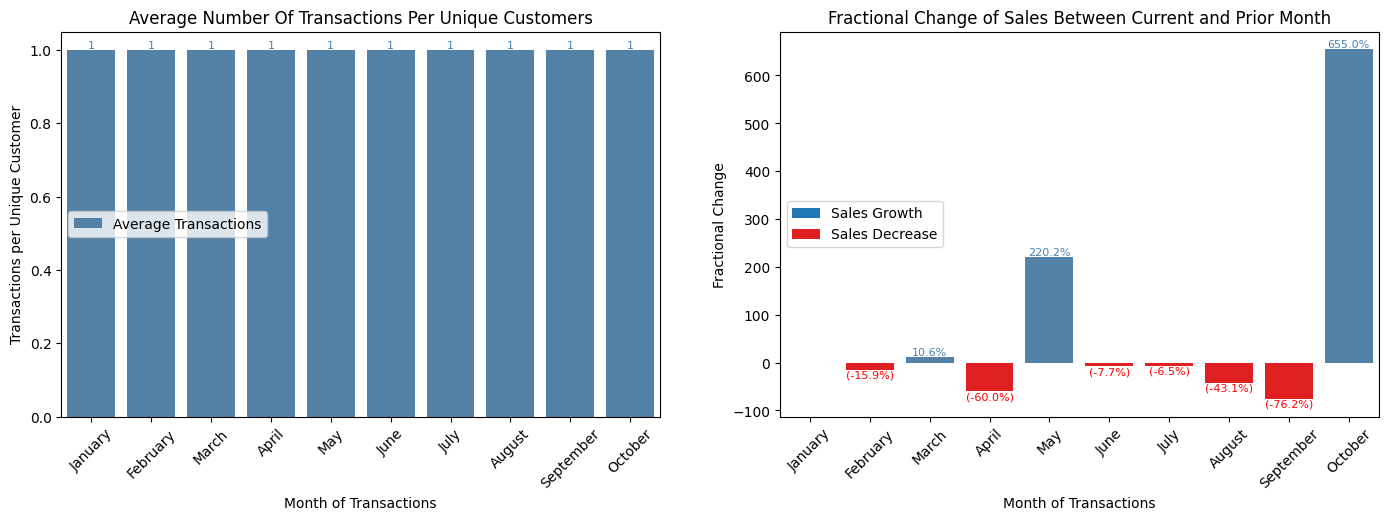

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

charts_column_label_data = [
    { 'title': 'Average Number Of Transactions Per Unique Customers',
      'y_column_name': 'transactions_per_customer_average', 'x_column_name': 'transaction_date_month_name', 'x_label': 'Month of Transactions', 'float_format': '%.0f',
      'y_label': 'Transactions per Unique Customer', 'color_split_column': 'transactions_per_customer_average', 'legend_labels': ['Average Transactions']
    },
    { 'title': 'Fractional Change of Sales Between Current and Prior Month',
      'y_column_name': 'amount_pct_change', 'x_column_name': 'transaction_date_month_name', 'x_label': 'Month of Transactions', 'float_format': '%.1f%%',
      'y_label': 'Fractional Change', 'color_split_column': 'amount_pct_change', 'legend_labels': ['Sales Growth', 'Sales Decrease']
    }
]

for ax, chart_data in zip(axs.flatten(), charts_column_label_data):

    colors_split = ['steelblue' if c >= 0 else 'red' for c in transactions_data_frame_and_customers_data_frame_merged_grouped_month[chart_data['color_split_column']]]
    sns.barplot(
        data=transactions_data_frame_and_customers_data_frame_merged_grouped_month,
        estimator=sum,
        y=chart_data['y_column_name'],
        x=chart_data['x_column_name'],
        errorbar=None,
        palette=colors_split,
        hue=chart_data['x_column_name'],
        ax=ax)

    # labels
    for i, container in enumerate(ax.containers):
        ax.bar_label(
            container,
            color=colors_split[i],
            fontsize=8,
            label_type='edge',
            fmt=(lambda x: chart_data['float_format'] % x if x > 0 else f'({chart_data["float_format"] % x})')
        )

    ax.set_title(chart_data['title'])
    ax.legend(labels=chart_data['legend_labels'], loc='center left')

    ax.set_xlabel(chart_data['x_label'], size=10)
    ax.set_ylabel(chart_data['y_label'], size=10)
    x_ticks = transactions_data_frame_and_customers_data_frame_merged_grouped_month[chart_data['x_column_name']].unique()
    ax.set_xticks(range(0, len(x_ticks)))
    ax.set_xticklabels(
        x_ticks,
        rotation=45, size=10
    )
    ax.grid(False)

plt.show()